# LAB 5: Data Generation, Density Recenstruction
### Parzen-Rosenblatt, LOO, EM Algorithms
### AI and Machine Learning // Suchkova Natalia М8О-114М-22
20.12.2022 @ MAI IT-Center

### Task
+ реализовать 3 генератора данных на плоскости, прямой или в пространстве (равномерное, Гаусс.распр, ... и др)
+ написать реализацию метода Парзена-Розенблатта
+ восстановить плотность в виде картинки
+ для 1 из 3 наборов данных (п.1) применить оптимизацию ширины окна методом LOO
+ для сгенерированных данных с 2-мя и более горбами применить EM-алгоритм (Gaussian Mixture) из sckit-learn

## Table of Contents

1. [**Function Optimization**](#op1)
    - [Rosenbrock](#op11)
    
    - [Himmelblau](#op12)
    

2. [**Optuna Scikitlearn Models' Parameter Opimization**](#op2)
    - [Study](#op21)
    
    - [Visuals](#op22)

In [1]:
import numpy as np
import random
import math

from typing import Mapping

from matplotlib import pyplot as plt
from mpl_toolkits import mplot3d

In [ ]:
seed = 11
rand_state = 11
rand = np.random.RandomState(seed)   

#### Равномерное (линейное) распределение

Cumulative distribution is:
$$
F(x) = \left\{
    \begin{array}\\
        0, & \text{for } x < a\\
        \frac{x-a}{b-a}, & \text{for }  a \leq x \leq b \\
        1, & \text{for } x > b\\
    \end{array}
\right.
$$


In [217]:
def genr_uniform(a:float = 0.0, b:float = 1.0, size:int = 1000) -> np.array:
    """
    Function: 
    Метод генерации точек по равномерному распределению с указанными параметрами а и b.

    Args: 
    a: float (default: 0.) - параметр рспределения: левая граница отрезка.
    b: float (default: 1.) - параметр рспределения: правая граница отрезка.
    size: int (default: 1000) - параметр генерацииЖ размер массива.

    Return:
    Массив значений случайно сгенерированных точек (float) при заданных параметрах равномерного
    распределения.
    """
    dist = np.random.uniform(a, b, size=(3, size))
    return dist

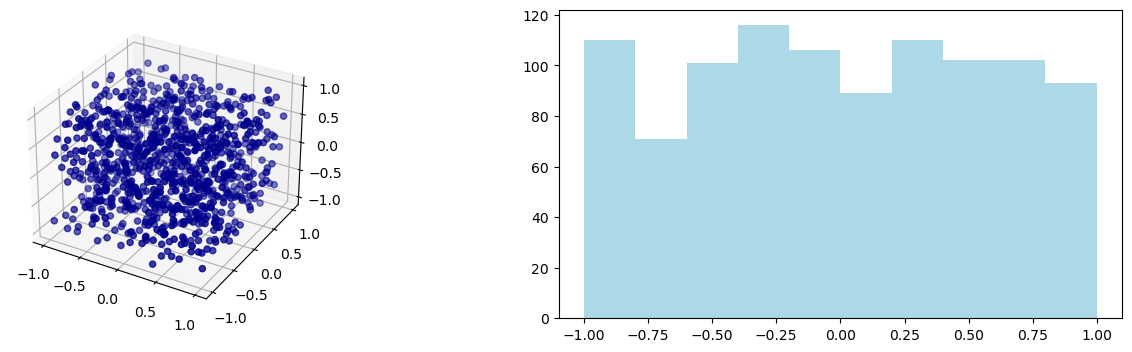

In [223]:
uni_dist = genr_uniform(a = -1)

fig = plt.figure(figsize=(16, 4))
# ax = plt.axes(projection="3d")
# ax.scatter3D(uni_dist[0], uni_dist[1], uni_dist[2])

ax = fig.add_subplot(1, 2, 1, projection="3d")
ax.scatter3D(uni_dist[0], uni_dist[1], uni_dist[2], color='darkblue')

ax = fig.add_subplot(1, 2, 2)
plt.hist(uni_dist[1], color='lightblue')
plt.show()

#### Гауссовское (нормальное) распределение
Cumulative distribution is:
$$ \Phi(x) = \frac{1}{\sqrt{2\pi}} \int\limits_{-\infty}^x e^{{}^-t^2/_2}\,\mathrm{d}x $$

In [224]:
def genr_normal(center: float = 0., std: float = 0.5, size: int = 1000) -> np.array:
    """
    Function: 
    Метод генерации точек по нормальному распределению с указанными параметрами center и std.

    Args: 
    center: float (default: 0.) - параметр рспределения: "центр" распределения.
    std: float (default: 0.5) - параметр рспределения: стандартное отклонение [0, 1].
    size: int (default: 1000) - параметр генерацииЖ размер массива.

    Return:
    Массив значений случайно сгенерированных точек (float) при заданных параметрах равномерного
    распределения.
    """
    dist = np.random.normal(center, std, size=(3, size))
    return dist

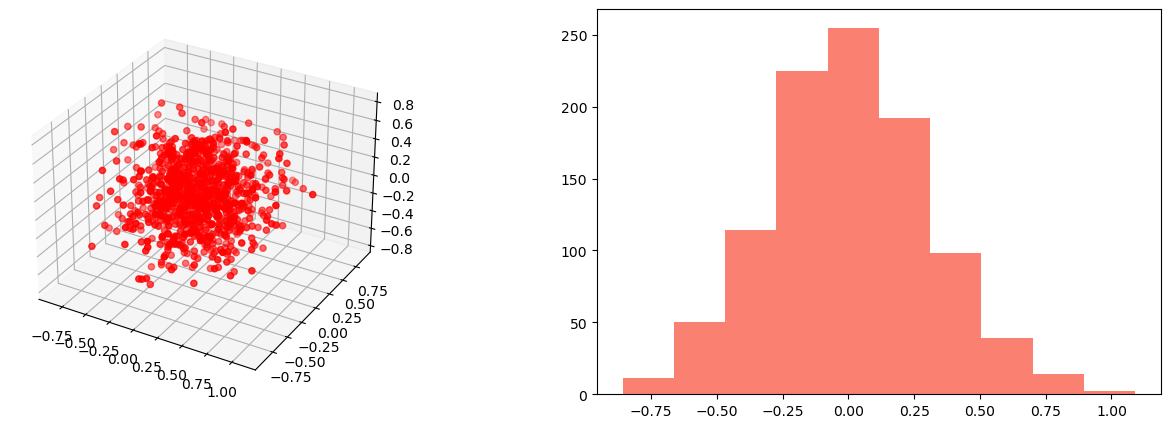

In [225]:
norm_dist = genr_normal(std=0.3)

fig = plt.figure(figsize=(16, 5))
ax = fig.add_subplot(1, 2, 1, projection="3d")
ax.scatter3D(norm_dist[0], norm_dist[1], norm_dist[2], color='red')

ax = fig.add_subplot(1, 2, 2)
plt.hist(norm_dist[0], color='salmon')

plt.show()

#### Бимодальное распределение (два пика)
Представляет собой сумму ограниченных распределений (любого типа) с различными параметрами.

In [244]:
def genr_mulmodal(size: int = 1000, n_peaks: int = 2) -> np.array:
    dist = np.random.poisson(10, size=(3, size // n_peaks))
    for p in range(n_peaks - 2):
        peak = np.random.normal(-10, 0.1, size=(3, size // n_peaks))
        np.append(dist, peak)
    peak2 = np.random.lognormal(mean=0.4, sigma=1.5, size=(3, size // n_peaks))
    np.append(dist, peak2)
    return dist

In [237]:
# def genr_mulmodal(size: int = 1000) -> np.array:
#     dist = np.random.normal(-10, 2, size=(3, size // 2))
#     peak = np.random.normal(10, 6, size=(3, size // 2))
#     np.append(dist, peak)
#     return dist

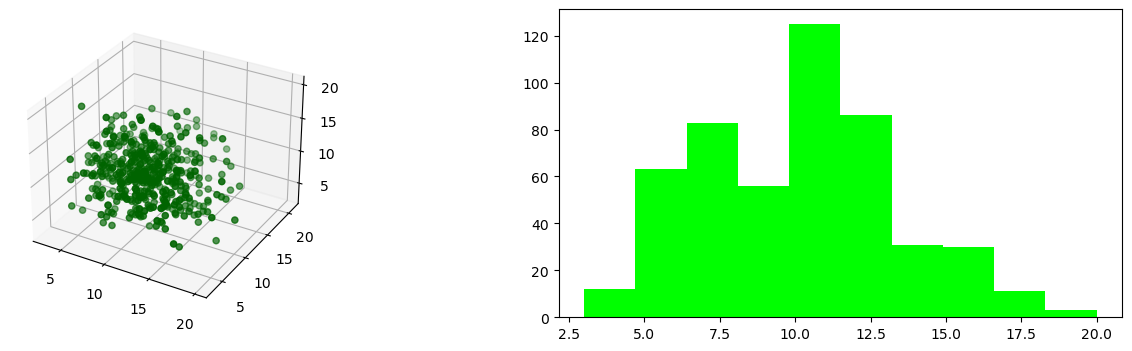

In [245]:
bi_dist = genr_mulmodal()

fig = plt.figure(figsize=(16, 4))
ax = fig.add_subplot(1, 2, 1, projection="3d")
ax.scatter3D(bi_dist[0], bi_dist[1], bi_dist[2], color='darkgreen')

ax = fig.add_subplot(1, 2, 2)
plt.hist(bi_dist[0], color='lime')

plt.show()

### Метод Парзена-Розенблатта